# Engine

This document describes the performance evaluation for [Typesense](https://typesense.org/).

For the sake of testing a local docker single-instance cluster was used via the following `docker-compose.yml`:

```yaml
version: '3.4'
services:
  typesense:
    image: typesense/typesense:0.24.0
    restart: on-failure
    ports:
      - "8108:8108"
    volumes:
      - ./typesense-data:/data
    command: '--data-dir /data --api-key=xyz --enable-cors'
```

The data used to test the engine comes from [the Lichess database](https://database.lichess.org) and represents chess games.
The full dataset can be downloaded using the following script:

```shell
#!/bin/bash

rm -rf datasets
mkdir datasets
cd datasets || exit

for i in $(seq -w 1 12); do
  curl https://database.lichess.org/standard/lichess_db_standard_rated_2013-"$i".pgn.zst -o lichess_db_standard_rated_2013-"$i".pgn.zst
  pzstd -d lichess_db_standard_rated_2013-"$i".pgn.zst
  rm lichess_db_standard_rated_2013-"$i".pgn.zst
done

date > downloaded_at.txt
```

For the sake of performance evaluation, a small set of 1 000 000 chess games was taken starting from the beginning of [the january 2013 standard games dataset](https://database.lichess.org/standard/lichess_db_standard_rated_2013-01.pgn.zst).

# Interfacing with the engine

Out of the box typesense does not provide any graphical user interface.
While there are client libraries provided by first party vendor as well as the community, they are simply thin wrappers over the REST HTTP API.

Quoting the website itself:
>Typesense has a RESTful API so it can be used with any HTTP library in any programming language, even the ones not listed below. The client libraries are just thin wrappers around Typesense's HTTP API.

# Indexing Metrics

The following code shows extraction of performance metrics from the server instance.

In [13]:
import os

typesense_url = "http://localhost:8108"
typesense_api_key = "xyz"
typesense_api_key_header = "X-TYPESENSE-API-KEY"
batch_size = 10_000
batch_count = 100
search_sequence = "e4 e6 d4 b6 a3 Bb7 Nc3 Nh6 Bxh6 gxh6 Be2"

In [14]:
import requests

measurements = []


# noinspection PyShadowingBuiltins
def human_size(bytes, units=None):
    if units is None:
        units = [' bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']
    return str(bytes) + units[0] if bytes < 1024 else human_size(bytes >> 10, units[1:])


def measure_metrics():
    measurement = requests.get(f"{typesense_url}/metrics.json",
                               headers={typesense_api_key_header: typesense_api_key}).json()
    measurements.append(measurement)
    return measurement


def display_metrics_text(measurement):
    print(f"CPU:                                  {measurement['system_cpu_active_percentage']}%")
    print(f"system_disk_used_bytes:               {human_size(int(measurement['system_disk_used_bytes']))}")
    print(f"system_memory_used_bytes:             {human_size(int(measurement['system_memory_used_bytes']))}")
    print(f"system_network_received_bytes:        {human_size(int(measurement['system_network_received_bytes']))}")
    print(f"system_network_sent_bytes:            {human_size(int(measurement['system_network_sent_bytes']))}")
    print(f"typesense_memory_active_bytes:        {human_size(int(measurement['typesense_memory_active_bytes']))}")
    print(f"typesense_memory_allocated_bytes:     {human_size(int(measurement['typesense_memory_allocated_bytes']))}")
    print(f"typesense_memory_mapped_bytes:        {human_size(int(measurement['typesense_memory_mapped_bytes']))}")
    print(f"typesense_memory_metadata_bytes:      {human_size(int(measurement['typesense_memory_metadata_bytes']))}")
    print(f"typesense_memory_fragmentation_ratio: {measurement['typesense_memory_fragmentation_ratio']}")
    print(f"typesense_memory_resident_bytes:      {human_size(int(measurement['typesense_memory_resident_bytes']))}")
    print(f"typesense_memory_retained_bytes:      {human_size(int(measurement['typesense_memory_retained_bytes']))}")

Create empty collection.

In [15]:
import chess.pgn
from datetime import datetime
import typesense
from timeit import default_timer as timer

typesense_client = typesense.Client({
    'nodes': [{
        'host': 'localhost',
        'port': '8108',
        'protocol': 'http'
    }],
    'api_key': 'xyz',
    'connection_timeout_seconds': 2
})

collection_name = 'chess'

schema = {
    'name': collection_name,
    'fields': [
        {'name': 'link', 'type': 'string'},  # [Site "https://lichess.org/j1dkb5dw"]
        {'name': 'timestamp_utc', 'type': 'int32'},  # [UTCDate "2012.12.31"] [UTCTime "23:04:12"]
        {'name': 'event', 'type': 'string'},  # [Event "Rated Classical game"]
        {'name': 'white', 'type': 'string'},  # [White "BFG9k"]
        {'name': 'black', 'type': 'string'},  # [Black "mamalak"]
        {'name': 'opening', 'type': 'string'},  # [Opening "French Defense: Normal Variation"]
        {'name': 'termination', 'type': 'string'},  # [Termination "Normal"]
        {'name': 'mainline_moves', 'type': 'string'},  # 1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2...
        # {'name': 'sequenced_moves', 'type': 'string'},  # e4 e6 d4 b6 a3 Bb7 Nc3 Nh6 Bxh6 gxh6 Be2...
    ],
    'default_sorting_field': 'timestamp_utc'
}

names = [x['name'] for x in typesense_client.collections.retrieve()]

if collection_name in names:
    typesense_client.collections[collection_name].delete()

print("before schema created")
display_metrics_text(measure_metrics())
print()
typesense_client.collections.create(schema)
print("after schema created")
display_metrics_text(measure_metrics())

before schema created
CPU:                                  0.00%
system_disk_used_bytes:               147GB
system_memory_used_bytes:             1GB
system_network_received_bytes:        18MB
system_network_sent_bytes:            35KB
typesense_memory_active_bytes:        70MB
typesense_memory_allocated_bytes:     44MB
typesense_memory_mapped_bytes:        137MB
typesense_memory_metadata_bytes:      11MB
typesense_memory_fragmentation_ratio: 0.36
typesense_memory_resident_bytes:      70MB
typesense_memory_retained_bytes:      189MB

after schema created
CPU:                                  2.44%
system_disk_used_bytes:               147GB
system_memory_used_bytes:             1GB
system_network_received_bytes:        18MB
system_network_sent_bytes:            38KB
typesense_memory_active_bytes:        70MB
typesense_memory_allocated_bytes:     45MB
typesense_memory_mapped_bytes:        137MB
typesense_memory_metadata_bytes:      11MB
typesense_memory_fragmentation_ratio: 0.36
types

Fill collection with data.

In [16]:
collection = typesense_client.collections[collection_name]

durations = []
search_durations = []

counter = 0
games = []


for path in os.listdir("datasets"):
    with open(f'datasets/{path}') as file:
        while True:
            game = chess.pgn.read_game(file)
            if game is None:
                break
            counter = counter + 1
            if counter > batch_size * batch_count:
                break

            date = game.headers.get('UTCDate')  # 2012.12.31
            time = game.headers.get('UTCTime')  # 23:04:12

            ts_game = {
                'id': game.headers.get('Site').split('/')[-1],  # [Site "https://lichess.org/j1dkb5dw"]
                'link': game.headers.get('Site'),
                'timestamp_utc': int(datetime.strptime(f'{date} {time}', '%Y.%m.%d %H:%M:%S').timestamp()),
                'event': game.headers.get('Event'),
                'white': game.headers.get('White'),
                'black': game.headers.get('Black'),
                'opening': game.headers.get('Opening'),
                'termination': game.headers.get('Termination'),
                'mainline_moves': str(game.mainline_moves()),
            }

            games.append(ts_game)

            if counter % batch_size == 0:
                start_timer = timer()
                collection.documents.import_(games, {
                    'action': 'upsert',
                })
                stop_timer = timer()
                result = collection.documents.search({
                    'q': search_sequence,
                    'query_by': 'mainline_moves'
                })
                duration = stop_timer - start_timer
                durations.append(duration)
                search_durations.append(result['search_time_ms'])
                measure_metrics()
                games = []
                print(f'Upsert batch {int(counter / batch_size)} in {duration * 1000:.2f}ms')



Upsert batch 1 in 717.80ms
Upsert batch 2 in 789.59ms
Upsert batch 3 in 776.41ms
Upsert batch 4 in 959.01ms
Upsert batch 5 in 903.97ms
Upsert batch 6 in 914.39ms
Upsert batch 7 in 884.63ms
Upsert batch 8 in 877.32ms
Upsert batch 9 in 881.46ms
Upsert batch 10 in 944.82ms
Upsert batch 11 in 925.95ms
Upsert batch 12 in 909.30ms
Upsert batch 13 in 867.75ms
Upsert batch 14 in 911.15ms
Upsert batch 15 in 899.76ms
Upsert batch 16 in 929.38ms
Upsert batch 17 in 921.05ms
Upsert batch 18 in 874.28ms
Upsert batch 19 in 958.85ms
Upsert batch 20 in 996.16ms
Upsert batch 21 in 931.38ms
Upsert batch 22 in 964.86ms
Upsert batch 23 in 914.84ms
Upsert batch 24 in 911.40ms
Upsert batch 25 in 918.71ms
Upsert batch 26 in 973.03ms
Upsert batch 27 in 923.19ms
Upsert batch 28 in 959.59ms
Upsert batch 29 in 929.83ms
Upsert batch 30 in 941.82ms
Upsert batch 31 in 962.22ms
Upsert batch 32 in 919.03ms
Upsert batch 33 in 903.19ms
Upsert batch 34 in 956.32ms
Upsert batch 35 in 957.10ms
Upsert batch 36 in 900.08ms
U

Analyze performance.

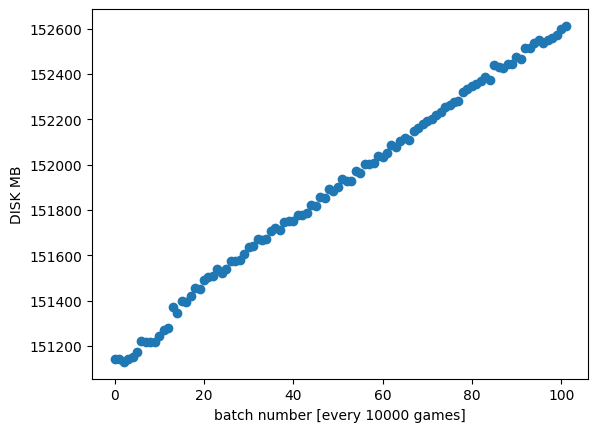

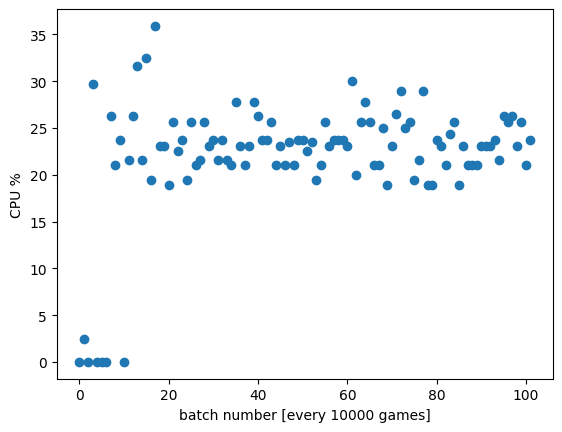

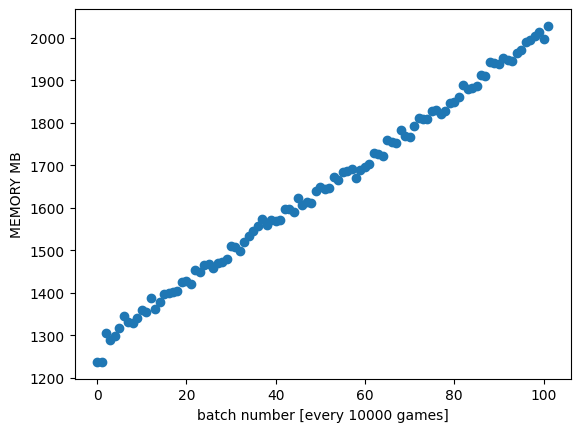

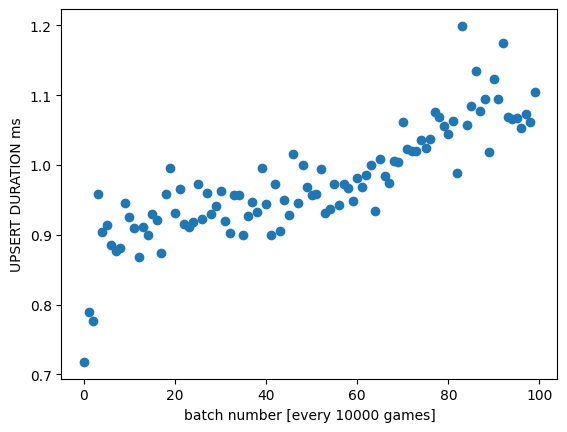

In [17]:
import matplotlib.pyplot as plt


def plot(data, name):
    x = [i for i, _ in enumerate(data)]
    y = data

    plt.xlabel(f'batch number [every {batch_size} games]')
    plt.ylabel(name)
    plt.scatter(x, y)
    plt.show()


def plot_metric(metric, name, transform=lambda x: x):
    plot([transform(measurement[metric]) for measurement in measurements], name)


plot_metric("system_disk_used_bytes", "DISK MB", lambda x: float(x) / 1024.0 / 1024.0)
plot_metric("system_cpu_active_percentage", "CPU %", lambda x: float(x))
plot_metric("system_memory_used_bytes", "MEMORY MB", lambda x: float(x) / 1024.0 / 1024.0)
plot(durations, "UPSERT DURATION ms")

# Search Metrics

For the sake of measuring search performance, an arbitrary sequence of moves is chosen from the first game in the dataset. The sequence is then used to search for games that contain the sequence as a subsequence of moves.

Search performance is evaluated by measuring the time it takes to return the first 10 results after each batch is indexed.

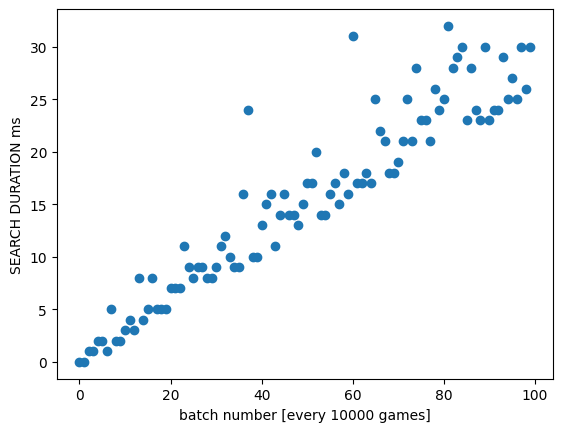

In [18]:
plot(search_durations, "SEARCH DURATION ms")

# Constraints and considerations

The engine keeps all indices in the operating memory (RAM). This means that the more data you index, the more memory the engine will consume. The engine does not support disk-based indices. Disk persistence is used for storing cold data (e.g. the index during node shutdown).

Typesense is designed to be used in a cluster of nodes but this benchmark did not take into consideration the performance differences between a single node and a cluster of nodes. It is possible that a cluster would intelligently split the load and achieve better performance.

Due to commercial memory constraints the expected size of data that can be indexed is limited to terabytes at maximum and thus the engine is not suitable for storing high volume data such as application logs.

The very fast response times make this engine an excellent choice for real-time recommendation systems. The engine is also suitable for search-as-you-type scenarios.
